# Image Classification

## Table of Contents
* [1. Setup and Load Data](#setup)
    - [1.1 Install Depedencies and Setup](#install)
    - [1.2 Remove Nonimages](#remove)
    - [1.3 Load Data](#load)
* [2. Preprocess Data](#preprocess)
    - [2.1 Data Augmentation](#augment)
    - [2.2 Configure the Dataset for Performance](#configure)
    - [2.3 Split Dataset](#split)
* [3. Deep Model](#deep_model)
    - [3.1 Build Deep Learning Model](#build_model)
    - [3.2 Train Model](#train)
    - [3.3 Plot Performance](#performance)
* [4. Evaluate Performance](#evaluation)
    - [4.1 K-Fold Cross Validation](#kfold)
    - [4.2 Testing Multiple Images](#test_multi)
    - [4.3 Testing Single Images](#test_single)
* [5. Save Model](#saving_model)

# 1. Setup and Load Data <a id="setup"></a>

### 1.1 Install Dependencies and Setup <a id="install"></a>

In [ ]:
!pip install tensorflow==2.10 tensorflow-gpu==2.10 opencv-python matplotlib

In [2]:
import tensorflow as tf
import os

In [3]:
## Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### 1.2 Remove Nonimages <a id="remove"></a>

In [4]:
import cv2
import imghdr

In [5]:
data_dir = 'data'
image_extensions = ['jpeg', 'jpg', 'bmp', 'png']

In [6]:
def remove_nonimage(image):
    try:
        img = cv2.imread(image)
        extension = imghdr.what(image)

        if extension not in image_extensions:
            print('Image not in extension list {}'.format(image))
            os.remove(image)
    except Exception as e:
        print('Issue with image {}'.format(image))
        os.remove(image)

for image_class in os.listdir(os.path.join(data_dir, 'training')):
    for image in os.listdir(os.path.join(data_dir, 'training', image_class)):
        image_path = os.path.join(data_dir, 'training', image_class, image)
        remove_nonimage(image_path)

### 1.3 Load Data <a id="load"></a>

Loads images into a data image pipeline. The <span style="color:#5886e8">image_dataset_from_directory</span> transforms data into a consistent shape and batch.  
All images transform to size 256x256 by default.

In [7]:
import numpy as np
from matplotlib import pyplot as plt

In [8]:
data_set = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'training'), 
    batch_size = 64)

Found 5947 files belonging to 6 classes.


In [9]:
class_names = data_set.class_names
class_names

['basketball',
 'bowling ball',
 'soccerball',
 'star',
 'tennisball',
 'volleyball']

In [10]:
data_iterator = data_set.as_numpy_iterator()
image, category = data_iterator.next()
print(image.shape)

(64, 256, 256, 3)


<span style="color:#5886e8">batch</span> has 2 indexes the image and the class of the image (int)

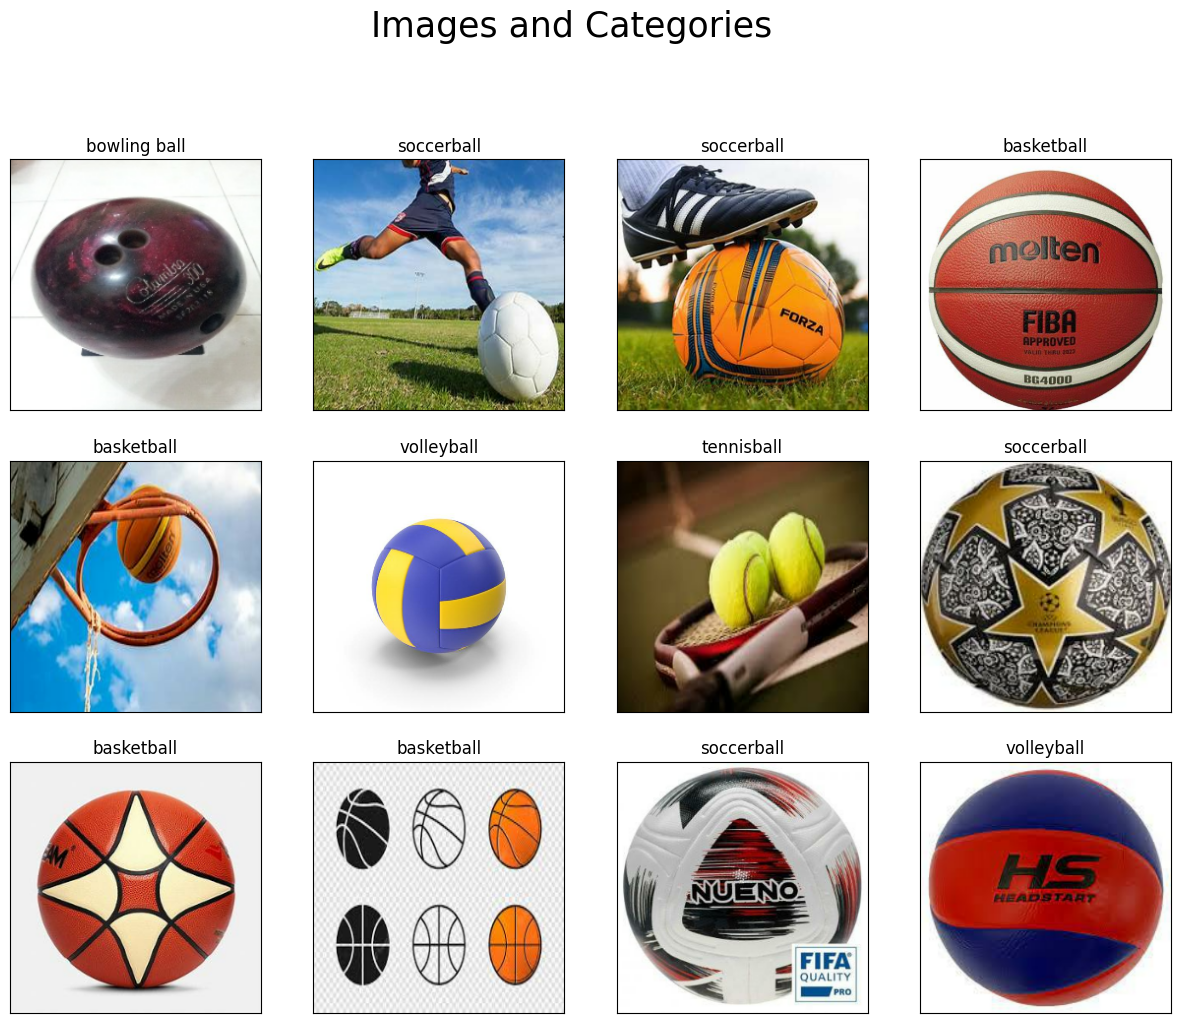

In [11]:
figsize = (15,15)
figure = plt.figure(figsize=figsize)
figure.suptitle("Images and Categories", fontsize=25)

for i in range(12):
    plt.subplot(4,4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image[i].astype(np.uint8))
    plt.title(class_names[category[i]])
plt.show()    

# 2. Preprocessing Data <a id="preprocess"></a>

### 2.1 Data Augmentation <a id="augment"></a>

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images.  
This helps expose the model to more aspects of the data and generalize better.

In [12]:
from keras.preprocessing.image import ImageDataGenerator

In [13]:
datagen = ImageDataGenerator(
        rotation_range=45,     # Random rotation between 0 and 45
        width_shift_range=0.2,   # % shift
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='constant', cval=125)    # Also try nearest, constant, reflect, wrap

In [14]:
for batch in datagen.flow_from_directory(directory= os.path.join(data_dir, 'folder_to_augment'), 
                                         batch_size=1000,  
                                         target_size=(256, 256),
                                         color_mode="rgb",
                                         save_to_dir=os.path.join(data_dir, 'augmented'), 
                                         save_prefix='aug', 
                                         save_format='jpg'):
    i += 1
    if i > 31:
        break

Found 0 images belonging to 0 classes.


### 2.2 Configure Dataset for Performance <a id="configure"></a>
* Scale the images values to be between 0-1 by dividing by 255. This helps our deep learning model journalize faster.   
* Prefectch data to overlap executing the training step and the reading data step.  
* Cache the dataset so file opening and data reading are done in the first epoch, then the next epochs will reuse the data cached.

In [15]:
data_scaled = data_set.map(lambda x, y: (x/255, y))

In [16]:
data_batch = data_scaled.as_numpy_iterator().next()

# Checking scaling
print(data_batch[0][0].min(), data_batch[0][0].max())

0.0 1.0


In [17]:
AUTOTUNE = tf.data.AUTOTUNE
data_scaled = data_scaled.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

### 2.3 Split Data <a id="split"></a>

In [18]:
training = data_scaled.take(int(len(data_scaled)*.8))
validation = data_scaled.skip(int(len(data_scaled)*.8)).take(int(len(data_scaled)*.2))

# 3. Deep Model <a id="deep_model"></a>

### 3.1 Build Deep Learning Model <a id="build_model"></a>

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Dense, Flatten

In [79]:
model = Sequential()

In [80]:
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(len(class_names)))

In [81]:
model.compile('adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [82]:
# Save weights to reset model for testing
saved_weights = model.get_weights()

In [83]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 16)      2320      
                                                                 
 conv2d_8 (Conv2D)           (None, 123, 123, 16)      2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 61, 61, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 59, 59, 32)       

### 3.2 Train Model <a id="train"></a>

In [84]:
history = model.fit(training, epochs=15, validation_data=validation)

Epoch 1/15
74/74 [==============================] - 4s 46ms/step - loss: 1.3286 - accuracy: 0.4878 - val_loss: 0.9695 - val_accuracy: 0.6380
Epoch 2/15
74/74 [==============================] - 3s 44ms/step - loss: 0.9177 - accuracy: 0.6681 - val_loss: 0.8246 - val_accuracy: 0.7062
Epoch 3/15
74/74 [==============================] - 3s 46ms/step - loss: 0.7778 - accuracy: 0.7301 - val_loss: 0.6913 - val_accuracy: 0.7698
Epoch 4/15
74/74 [==============================] - 3s 46ms/step - loss: 0.6468 - accuracy: 0.7740 - val_loss: 0.5759 - val_accuracy: 0.8003
Epoch 5/15
74/74 [==============================] - 3s 44ms/step - loss: 0.5277 - accuracy: 0.8195 - val_loss: 0.4502 - val_accuracy: 0.8576
Epoch 6/15
74/74 [==============================] - 3s 44ms/step - loss: 0.4253 - accuracy: 0.8579 - val_loss: 0.3410 - val_accuracy: 0.9085
Epoch 7/15
74/74 [==============================] - 3s 45ms/step - loss: 0.3560 - accuracy: 0.8806 - val_loss: 0.3637 - val_accuracy: 0.8828
Epoch 8/15
74

### 3.3 Plot Performance <a id="performance"><a/>

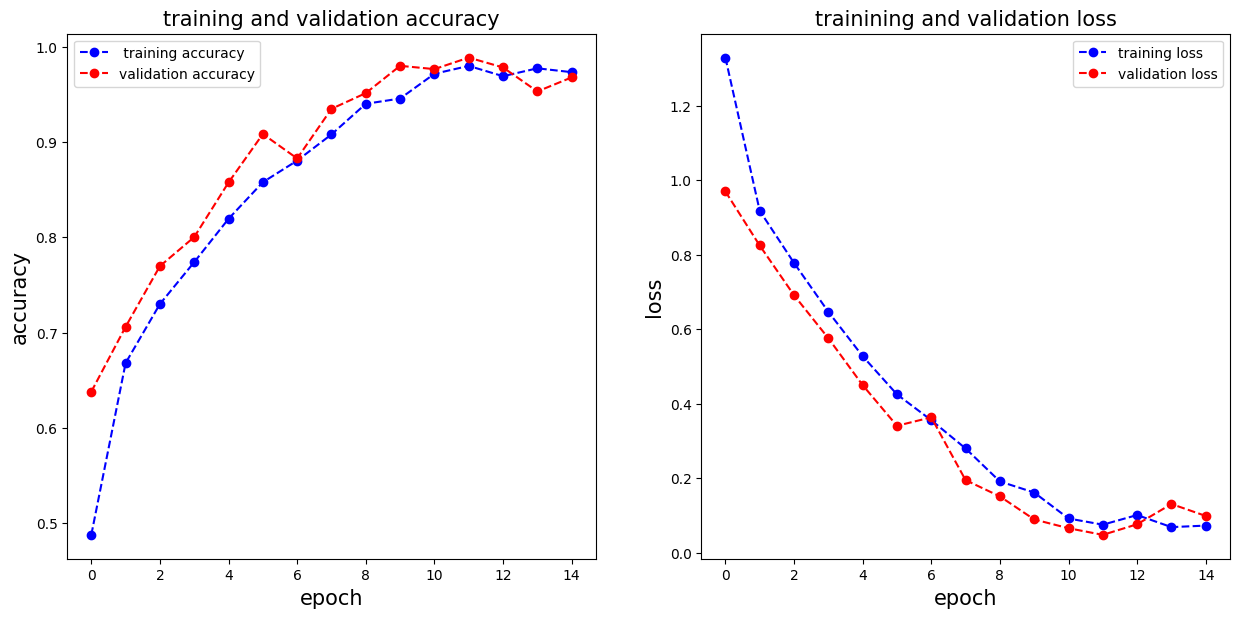

In [85]:
figure = plt.figure(figsize=(15,15))

# Plot accuracy
plt.subplot(221)
plt.plot(history.history['accuracy'], 'bo--', label = ' training accuracy')
plt.plot(history.history['val_accuracy'], 'ro--', label = 'validation accuracy')
plt.title('training and validation accuracy', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.legend()

# Plot loss function
plt.subplot(222)
plt.plot(history.history['loss'], 'bo--', label = 'training loss')
plt.plot(history.history['val_loss'], 'ro--', label = 'validation loss')
plt.title('trainining and validation loss', fontsize=15)
plt.ylabel('loss', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.legend()

plt.show()

# 4. Evaluate Performance <a id='evaluation'></a>

### 4.1 K-Fold Cross Validation <a id="kfold"></a>

In [75]:
import math

In [936]:
def prediction_score(prediction):
    value_list = []
    
    for i in range(len(prediction)):
        score = tf.nn.softmax(prediction[i])
        value_list.append(np.argmax(score))
    return value_list

def get_test_results(test):
    test_score = []
    prediction_list = []
    
    for batch in test.as_numpy_iterator():
        imgs, val = batch

        predict = model.predict(imgs, verbose = 0)
        prediction_list = np.append(prediction_list, prediction_score(predict))
        test_score = np.append(test_score, val)
    
    return prediction_list, test_score

In [937]:
def kfold_validation(data, k_fold):
    data_len = len(data)

    for k in range(k_fold):
        predict_list = []
        test_list = []
        percent = 1. / k_fold
        
        # Split train and test
        first_seg = int(round(data_len*(percent*k)))
        test_seg = int(round(data_len*percent))
        second_seg = int(round(data_len*((1-percent) - percent*k)))

        t1 = data.take(first_seg)
        test = data.skip(first_seg).take(test_seg)
        t2 = data.skip(first_seg + test_seg).take(second_seg)
        train = t1.concatenate(t2)
        
        # Reset weights and train model folds
        model.set_weights(saved_weights)
        model.fit(train, epochs=10)
        
        # Put results on a list
        predictions, test_score = get_test_results(test)
        predict_list = np.append(predict_list, predictions)
        test_list = np.append(test_list, test_score)
        
        print(classification_report(test_list, predict_list))

In [938]:
kfold_validation(training, 5)

Epoch 1/10
59/59 [==============================] - 3s 44ms/step - loss: 1.4110 - accuracy: 0.4227
Epoch 2/10
59/59 [==============================] - 2s 42ms/step - loss: 1.0915 - accuracy: 0.5824
Epoch 3/10
59/59 [==============================] - 2s 42ms/step - loss: 0.9205 - accuracy: 0.6692
Epoch 4/10
59/59 [==============================] - 2s 40ms/step - loss: 0.8264 - accuracy: 0.7043
Epoch 5/10
59/59 [==============================] - 2s 41ms/step - loss: 0.7106 - accuracy: 0.7444
Epoch 6/10
59/59 [==============================] - 2s 41ms/step - loss: 0.6668 - accuracy: 0.7658
Epoch 7/10
59/59 [==============================] - 2s 42ms/step - loss: 0.5533 - accuracy: 0.8030
Epoch 8/10
59/59 [==============================] - 2s 41ms/step - loss: 0.4922 - accuracy: 0.8279
Epoch 9/10
59/59 [==============================] - 2s 41ms/step - loss: 0.4046 - accuracy: 0.8648
Epoch 10/10
59/59 [==============================] - 2s 41ms/step - loss: 0.3181 - accuracy: 0.8867
         

### 4.2 Test Multiple Images <a id="test_multi"></a>

In [76]:
from sklearn.metrics import classification_report

In [86]:
testing = tf.keras.utils.image_dataset_from_directory(os.path.join(data_dir, 'test'), batch_size=64)
scaled_test = testing.map(lambda x, y: (x/255, y))

testing_iterator = scaled_test.as_numpy_iterator()
batch = testing_iterator.next()

Found 35 files belonging to 6 classes.


In [87]:
test_category = testing.class_names
case_score = batch[1]
test_list = []
predict_list = []

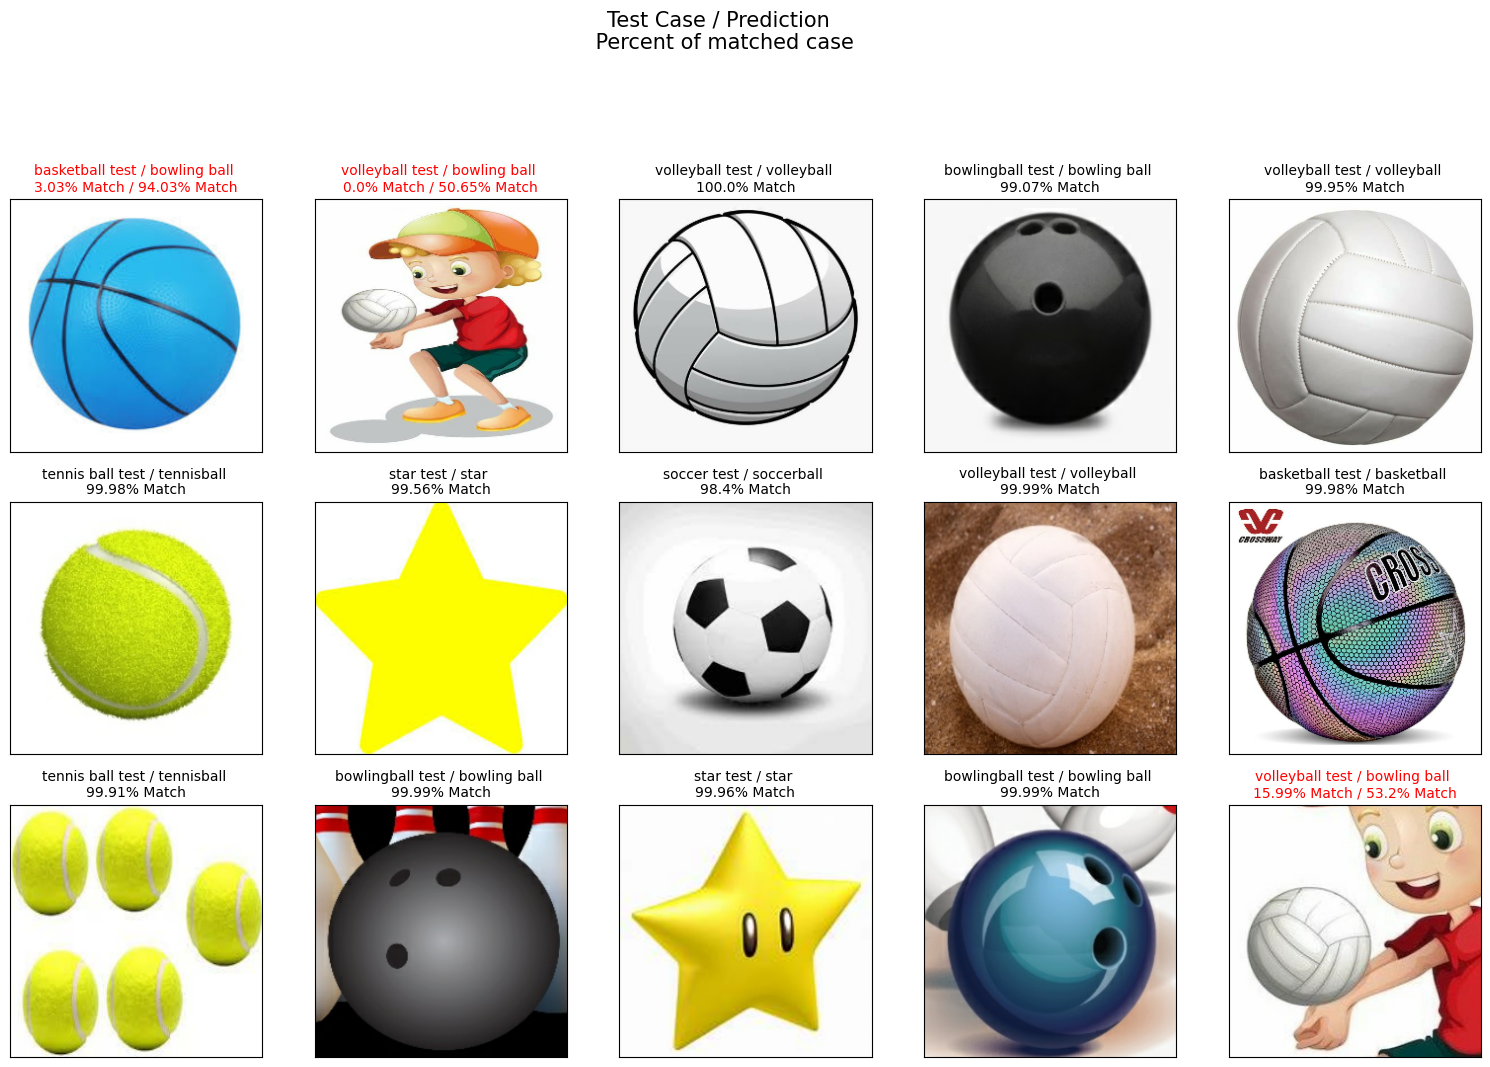

In [104]:
figsize = (19,19)
figure = plt.figure(figsize=figsize)
figure.suptitle("Test Case / Prediction \n Percent of matched case", fontsize=15)

for i in range(35):
    predict = model.predict(np.expand_dims(batch[0][i], 0), verbose = 0)
    score = tf.nn.softmax(predict[0])

    test_case = test_category[case_score[i]]
    predict_case = class_names[np.argmax(score)]
    percent_pred = round(100*np.max(score), 2)
    percent_test = round(100*np.array(score[case_score[i]]), 2)

    if(case_score[i] != np.argmax(score)):
        font_color = 'red'
        text = f"{test_case} / {predict_case} \n{percent_test}% Match / {percent_pred}% Match"
    else:
        font_color = 'black'
        text = f"{test_case} / {predict_case} \n{percent_test}% Match"
    
    plt.subplot(5,5, i+1)
    plt.title(text, fontsize=10, color=font_color)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(batch[0][i])
    
    test_list = np.append(test_list, case_score[i])
    predict_list = np.append(predict_list, np.argmax(score))

In [89]:
print(classification_report(test_list, predict_list))

              precision    recall  f1-score   support

         0.0       1.00      0.71      0.83         7
         1.0       0.56      1.00      0.71         5
         2.0       1.00      0.83      0.91         6
         3.0       1.00      1.00      1.00         4
         4.0       0.86      1.00      0.92         6
         5.0       1.00      0.71      0.83         7

    accuracy                           0.86        35
   macro avg       0.90      0.88      0.87        35
weighted avg       0.91      0.86      0.86        35



In [90]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

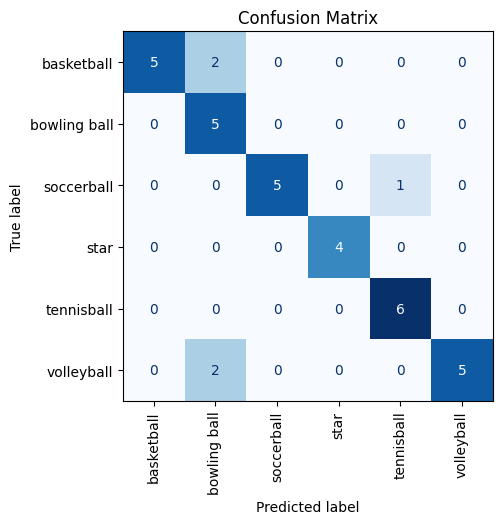

In [91]:
con_matrix = confusion_matrix(test_list, predict_list)
display_matrix = ConfusionMatrixDisplay(con_matrix, display_labels=class_names)
display_matrix.plot(colorbar=False, cmap='Blues')
plt.title("Confusion Matrix")
plt.xticks(rotation=90)
plt.show()

### 4.3 Test Single Images <a id="test_single"></a>

In [92]:
test_path = 'soccer test\\soccerball.jpg'
img = cv2.imread(os.path.join('data\\test', test_path))

resize images and setting color to RGB to match the format of our training dataset

In [93]:
resize = tf.image.resize(img, (256, 256))
resize = cv2.cvtColor(resize.numpy(), cv2.COLOR_BGR2RGB)

In [94]:
predict = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 14ms/step


In [95]:
score = tf.nn.softmax(predict[0])
test_case = os.path.dirname(test_path)
predict_case = class_names[np.argmax(score)]
percent_match = round(100 * np.max(score), 2)

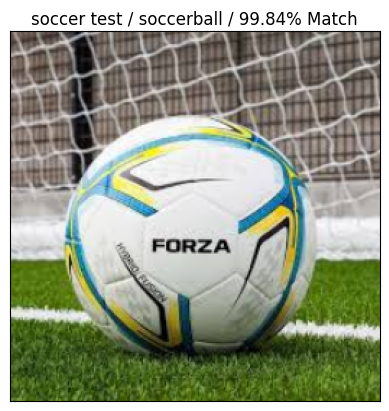

In [96]:
plt.imshow(resize.astype(int))
plt.xticks([])
plt.yticks([])
plt.title(f"{test_case} / {predict_case} / {percent_match}% Match")
plt.show()

# 5. Save Model <a id="saving_model"></a>

In [97]:
from tensorflow.keras.models import load_model

In [98]:
model.save(os.path.join('models', 'imageclassification.h5'))

In [99]:
new_model = load_model('models\\imageclassification.h5')

In [100]:
predict = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 64ms/step


In [101]:
score = tf.nn.softmax(predict[0])
test_case = os.path.dirname(test_path)
predict_case = class_names[np.argmax(score)]
percent_match = round(100 * np.max(score), 2)

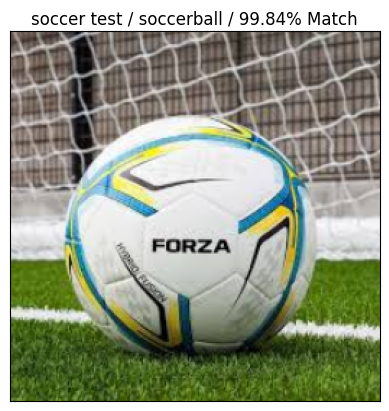

In [102]:
plt.imshow(resize.astype(int))
plt.xticks([])
plt.yticks([])
plt.title(f"{test_case} / {predict_case} / {percent_match}% Match")
plt.show()